In [8]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matyplotlib -rf

Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [12]:
plt.rc('font', family='NanumBarunGothic')

  target_date  sku_id          product_code  actual       pred  cat_low
0  2025-01-06       1  TV-SAM-55인치-4K-00001      24  21.482351  UNKNOWN
1  2025-01-13       1  TV-SAM-55인치-4K-00001      26  25.466329  UNKNOWN
2  2025-01-20       1  TV-SAM-55인치-4K-00001      48  27.790324  UNKNOWN
3  2025-01-27       1  TV-SAM-55인치-4K-00001      20  38.863921  UNKNOWN
4  2025-02-03       1  TV-SAM-55인치-4K-00001      29  26.757551  UNKNOWN


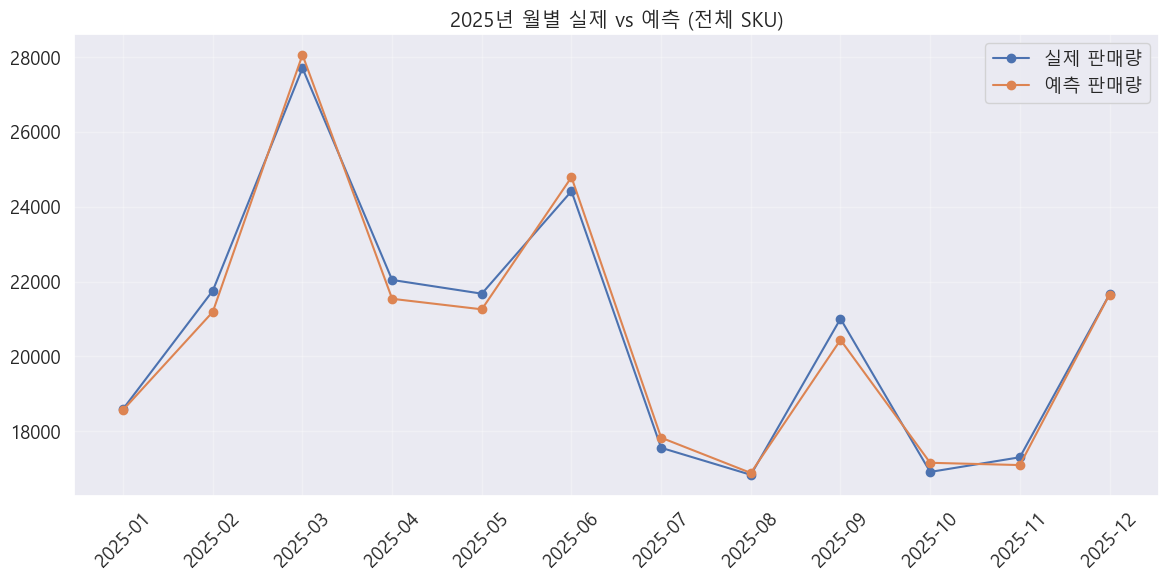


MAE 큰 SKU TOP10
                product_code        mae
133   PHN-LG-128GB-화이트-00200  30.392098
138   PHN-SAM-256GB-블랙-00197  29.010831
187   WAT-SAM-44MM-실리콘-00206  19.958679
130   PHN-APP-256GB-블랙-00193  19.141064
135   PHN-LG-256GB-화이트-00202  18.149521
129  PHN-APP-128GB-화이트-00192  17.144908
12    AIR-SAM-10평-HEPA-00071  16.655753
14    AIR-SAM-15평-HEPA-00073  16.492716
184   WAT-APP-40MM-실리콘-00203  16.084981
185   WAT-APP-44MM-실리콘-00204  15.660308

카테고리별 MAPE
Empty DataFrame
Columns: [MAPE]
Index: []


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_23388\4157987620.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g["actual"], g["pred"]))
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_23388\4157987620.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(safe_mape)


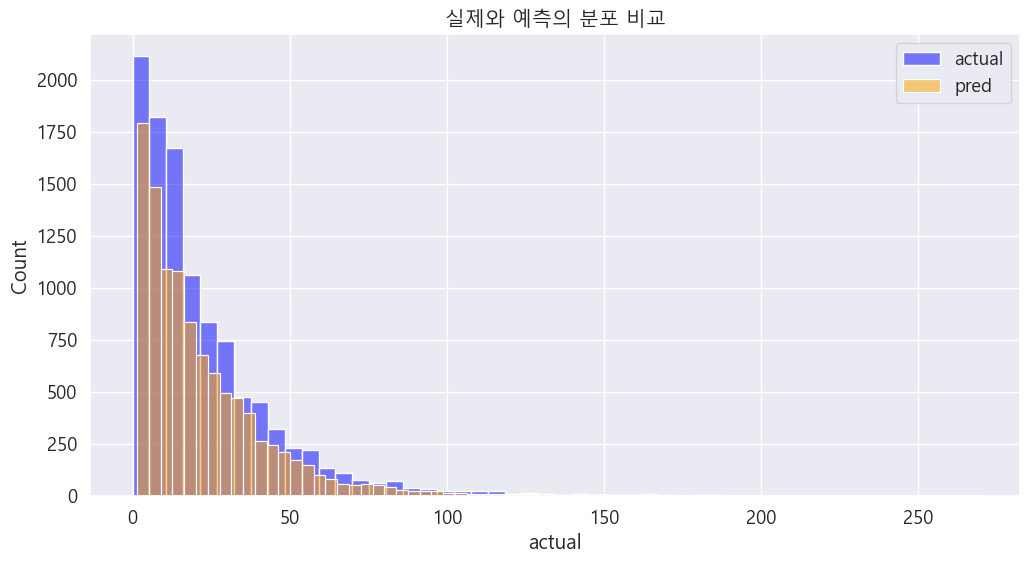

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

sns.set(font_scale=1.2)
plt.rcParams["font.family"] = "Malgun Gothic"  # Windows 한글 폰트


# ------------------------------------------------------------
# 1) 파일 로드
# ------------------------------------------------------------
BASE = Path("../app/data_pipeline")  # 자신의 경로 맞게 수정
eval_path = BASE / "eval_2025_pred_vs_actual.csv"
sku_path = BASE / "sku_catalog_ml.csv"

df = pd.read_csv(eval_path, parse_dates=["target_date"])

# SKU 카탈로그 가져오기
sku = pd.read_csv(sku_path)
sku = sku[["product_code", "cat_low"]].drop_duplicates()

df = df.merge(sku, on="product_code", how="left")
df["cat_low"] = df["cat_low"].fillna("UNKNOWN")

df.rename(columns={"y": "actual", "y_pred": "pred"}, inplace=True)

print(df.head())


# ------------------------------------------------------------
# 2) 월별 합계 (전체 SKU)
# ------------------------------------------------------------
df["month"] = df["target_date"].dt.to_period("M").astype(str)

monthly = df.groupby("month").agg({
    "actual": "sum",
    "pred": "sum"
}).reset_index()


plt.figure(figsize=(14, 6))
plt.plot(monthly["month"], monthly["actual"], marker="o", label="실제 판매량")
plt.plot(monthly["month"], monthly["pred"], marker="o", label="예측 판매량")
plt.xticks(rotation=45)
plt.title("2025년 월별 실제 vs 예측 (전체 SKU)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# ------------------------------------------------------------
# 3) SKU별 MAE TOP10
# ------------------------------------------------------------
sku_mae = (
    df.groupby("product_code")
      .apply(lambda g: mean_absolute_error(g["actual"], g["pred"]))
      .reset_index(name="mae")
      .sort_values("mae", ascending=False)
      .head(10)
)

print("\nMAE 큰 SKU TOP10")
print(sku_mae)


# ------------------------------------------------------------
# 4) 카테고리별 MAPE
# ------------------------------------------------------------

def safe_mape(g):
    if (g["actual"] == 0).any():
        return None  # Zero division 방지
    return mean_absolute_percentage_error(g["actual"], g["pred"]) * 100

cat_mape = (
    df.groupby("cat_low")
      .apply(safe_mape)
      .reset_index(names="MAPE")
)

print("\n카테고리별 MAPE")
print(cat_mape)


# ------------------------------------------------------------
# 5) 실제/예측 분포 히스토그램
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df["actual"], bins=50, label="actual", color="blue", alpha=0.5)
sns.histplot(df["pred"], bins=50, label="pred", color="orange", alpha=0.5)
plt.legend()
plt.title("실제와 예측의 분포 비교")
plt.show()
